In [1]:
!pip install "gym[classic_control]"


[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import gym

env = gym.make('CartPole-v0', render_mode='human')

/Users/kyunghokim/.pyenv/versions/3.8.18/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [2]:
state = env.reset()[0]
print('상태:', state)

action_space = env.action_space
print('행동의 차원수:', action_space)

env.render()

상태: [ 0.01005215  0.02043618 -0.00885032  0.007339  ]
행동의 차원수: Discrete(2)


In [3]:
import numpy as np
# import gym

# env = gym.make('CartPole-v0', render_mode='human')
### 별도 셀로 구분

state = env.reset()[0]
env.render()
done = False
rewards = 0

# 랜덤하게 움직인다면

while not done:
    env.render()
    action = np.random.choice([0, 1]) #행동 선택 (무작위)
    # print(action)
    next_state, reward, terminated, truncated, info = env.step(action)
    # print(next_state, reward, terminated, truncated, info)
    done = terminated | truncated
    rewards += reward

print(rewards)
# env.close()


20.0


In [4]:
from collections import deque
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)
    
    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)
        # print(data)

        # state = np.stack([x[0] if isinstance(x[0], np.ndarray) else x[0][0] for x in data]) ## (array([ 0.0024583 , -0.00793713,  0.02181692,  0.02300685], dtype=float32), {}) 와 같이 {})으로 끝나는 tuple인 경우가 있어서, 
        state = torch.tensor(np.stack([x[0][0] if isinstance(x[0], tuple) else x[0] for x in data])) ## (array([ 0.0024583 , -0.00793713,  0.02181692,  0.02300685], dtype=float32), {}) 와 같이 {})으로 끝나는 tuple인 경우가 있어서, 

        action = torch.tensor(np.array([x[1] for x in data]).astype(np.long))
        reward = torch.tensor(np.array([x[2] for x in data]).astype(np.float32))
        next_state = torch.tensor(np.stack([x[3] for x in data]))
        done = torch.tensor(np.array([x[4] for x in data]).astype(np.int32))
        return state, action, reward, next_state, done

        

In [5]:
### 좌측으로만 간다면

import gym

env = gym.make('CartPole-v0', render_mode='human')
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10): ## episode 10회 수행
    state = env.reset()
    done = False
    
    while not done:
        action = 0 ## 항상 0번 (좌측) 액션만 수행

        # 경험 데이터 획득
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        replay_buffer.add(state, action, reward, next_state, done) ## 버퍼에 추가
        state = next_state

print('replay_buffer 길이 :', len(replay_buffer))

## 경험데이터로부터 미니배치 생성
state, action, reward, next_state, done = replay_buffer.get_batch()

print(state.shape)
print(action.shape)
print(reward.shape)
print(next_state.shape)
print(done.shape)

print(state.dtype)
print(action.dtype)
print(reward.dtype)
print(next_state.dtype)
print(done.dtype)

/Users/kyunghokim/.pyenv/versions/3.8.18/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


replay_buffer 길이 : 90
torch.Size([32, 4])
torch.Size([32])
torch.Size([32])
torch.Size([32, 4])
torch.Size([32])
torch.float32
torch.int64
torch.float32
torch.float32
torch.int32


/var/folders/7w/922dx2h160n_dwt0x1j9_dth0000gp/T/ipykernel_92326/3331756797.py:28: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  action = torch.tensor(np.array([x[1] for x in data]).astype(np.long))


In [6]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class QNet(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x
    
class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000 ## 경험재생 크기
        self.batch_size = 32 ## 미니배치 크기
        self.action_size = 2 ## 0 아니면 1

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size) ## 원본신경망
        self.qnet_target = QNet(self.action_size) ## 목표신경망
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=self.lr)

    def sync_qnet(self): ## 두 신경망 동기화
        # self.qnet_target = copy.deepcopy(self.qnet) ## shallow copy(copy.copy) 실행시에는 두 신경망은 물리적으로 하나인 가중치 파라미터를 공유하게 됨. copy.deepcopy 를 실행해야 모든 데이터를 완벽하게 복제.
        self.qnet_target.load_state_dict(self.qnet.state_dict())

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.tensor(state[np.newaxis, :]) #배치처리용 차원 추가
            qs = self.qnet(state)
            # return qs.data.argmax()
            return qs.argmax().item()
        
    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return  # 데이터가 미니배치사이즈만큼 쌓이지 않았다면 여기서 끝낸다.
        
        # 미니배치 크기 이상이 쌓이면 미니배치를 생성
        state, action, reward, next_state, done = self.replay_buffer.get_batch()

        qs = self.qnet(state) #state (32,4)의 인풋을 받아서 각 0,1 각 행동에 대한 Q함수 출력 (32,2) 
        q = qs[np.arange(self.batch_size), action] ## 32개의 action에 해당하는 원소를 가져옴

        next_qs = self.qnet_target(next_state) # 다음 상태의 q함수 값을 구함. 단, qnet_target을 사용하는 점에 주목할 것.
        next_q = next_qs.max(1)[0] # 최댓값을 구한다.
        
        next_q.detach()
        target = reward + (1 - done) * self.gamma * next_q

        loss_fn = nn.MSELoss()
        loss = loss_fn(q, target)

        # self.qnet.cleargrads()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



In [7]:
episodes = 300
sync_interval = 20
env = gym.make('CartPole-v0', render_mode='human')
agent = DQNAgent()
reward_history = []

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated

        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    print(episode, total_reward)

0 8.0
1 11.0
2 8.0


/var/folders/7w/922dx2h160n_dwt0x1j9_dth0000gp/T/ipykernel_92326/3331756797.py:28: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  action = torch.tensor(np.array([x[1] for x in data]).astype(np.long))


3 8.0
4 9.0
5 9.0
6 10.0
7 10.0
8 12.0
9 9.0
10 11.0
11 10.0
12 9.0
13 8.0
14 8.0
15 9.0
16 11.0
17 10.0
18 11.0
19 9.0
20 10.0
21 10.0
22 10.0
23 9.0
24 12.0
25 11.0
26 9.0
27 9.0
28 9.0
29 10.0
30 10.0
31 12.0
32 10.0
33 9.0
34 9.0
35 10.0
36 10.0
37 10.0
38 9.0
39 9.0
40 9.0
41 10.0
42 9.0
43 10.0
44 14.0
45 11.0
46 9.0
47 11.0
48 9.0
49 10.0
50 9.0
51 11.0
52 9.0
53 11.0
54 12.0
55 11.0
56 9.0
57 11.0
58 10.0
59 10.0
60 9.0
61 8.0
62 12.0
63 10.0
64 27.0
65 14.0
66 9.0
67 10.0
68 9.0
69 10.0
70 10.0
71 10.0
72 9.0
73 10.0
74 9.0
75 10.0
76 10.0
77 10.0
78 9.0
79 9.0
80 8.0
81 8.0
82 19.0
83 12.0
84 13.0
85 10.0
86 10.0
87 135.0
88 11.0
89 11.0
90 15.0
91 72.0
92 48.0
93 41.0
94 35.0
95 26.0
96 11.0
97 68.0
98 30.0
99 16.0
100 20.0
101 30.0
102 16.0
103 22.0
104 26.0
105 24.0
106 29.0
107 44.0
108 24.0
109 28.0
110 20.0
111 48.0
112 19.0
113 29.0
114 43.0
115 29.0
116 55.0
117 32.0
118 44.0
119 32.0
120 46.0
121 40.0
122 30.0
123 140.0
124 200.0
125 200.0
126 200.0
127 200.0
128 200

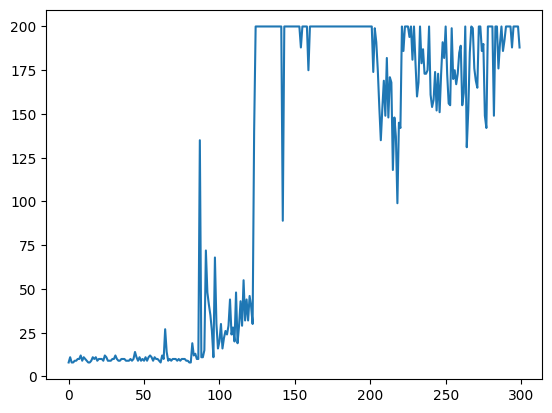

In [8]:
import matplotlib.pyplot as plt
plt.plot(reward_history)